In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('../2 - makemore/names.txt', 'r').read().splitlines()
words[:8]
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


# Build dataset


In [6]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

for x, y in zip(Xtr[:20], Ytr[:20]):
	# print(x,y)
	print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])
## Mmm tasty x -> y examples (we got 182625 training examples hehe)

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])
........ ---> e
.......e ---> b
......eb ---> r
.....ebr ---> i
....ebri ---> m
...ebrim ---> a
..ebrima ---> .
........ ---> h
.......h ---> i
......hi ---> l
.....hil ---> t
....hilt ---> o
...hilto ---> n
..hilton ---> .
........ ---> j
.......j ---> h
......jh ---> e
.....jhe ---> n
....jhen ---> e
...jhene ---> .


# NN classes and model 

In [8]:
### Network stuff
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------

class BatchNorm1d:
# With the fixed bug ofc (i.e considers 2 batch dimensions aswell)
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training: # checks 2d/3d. Bit different from pytorch implementation: We assume the last dim is what we want, it assumes first dim (dim 1) is what we want.
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

class Embedding:
	def __init__(self, num_embeddings, embedding_dim) -> None:
		""" Embedding class for generating one in the forward pass

		Args:
			num_embeddings: number of embeddings you want to have (like vocab size -- the alphabet -- how many items do you want in a vector representation)
			embedding_dim: size of each embedding
		"""
		
		self.weight = torch.randn((num_embeddings, embedding_dim))

	def __call__(self, IX):
		"""_summary_

		Args:
			IX (_type_): Index of the embedding you want (e.g index 26 would be z, index 0 is '.')

		Returns:
			_type_: _description_
		"""
		self.out = self.weight[IX]
		# print("Hey, I'm in embedding!:", self.out.shape)
		return self.out

	def parameters(self):
		return [self.weight]
# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  # See the makemore-wavenet notebook for COMMENTS GALORE as to how this works.
  # Tldr, it takes Embedding's output (or any layer output) -- say (4,8,10) -- and flattens into (4,4, 20). I.e, it concatenates 2 chars/superchars... together, and moves on with its life.

  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  # To make everything like lego blocks. Yay!
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    # Call all layers sequentially given some input and return the output.
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

### Network initialisation

In [9]:
torch.manual_seed(42); # seed rng for reproducibility

In [16]:
## Boooom! Yeah, we basically just increased our embed size to 24 haha
n_embd = 24 
n_hidden = 128 
model =  Sequential([
	Embedding(vocab_size, n_embd), 
	FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	Linear(n_hidden, vocab_size)
])

# parameter init
# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident
  
parameters = model.parameters() # boom!
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
	p.requires_grad = True

76579


### Training the model

In [17]:
# same optimization as last time

def train_sequential_model(model, max_steps = 20000, batch_size = 32):
	lossi = []
	for i in range(max_steps):
		# minibatch construct
		ix = torch.randint(0, Xtr.shape[0], (batch_size,))
		Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

		# forward pass
		logits = model(Xb) # Boom! Just call the model, inputting Xb, and viola! Your logits (by definition, the output of your NN after its layer processing) are here :D
		loss = F.cross_entropy(logits, Yb) # loss function
		
		# backward pass
		for p in parameters:
			p.grad = None
		loss.backward()
		
		# update: simple SGD - could try adam if you want :o
		lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
		for p in parameters:
			# print(p.grad)
			p.data += -lr * p.grad

		# track stats
		if i % 1000 == 0: # print every once in a while
			print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
		lossi.append(loss.log10().item())
	return lossi # this is just for plotting loss :) etc. Not needed at all. 
# Tbh, I think having the lossi thing inside model might be better, so then when we rerun this function over and over, the model keeps the lossi, instead of having it reset here and get its loss graph messed up (since lossi resets here but ofc model keeps its learnt weights).

In [18]:
lossi = train_sequential_model(model)

      0/  20000: 3.3144
   1000/  20000: 2.4076
   2000/  20000: 2.0531
   3000/  20000: 2.3900
   4000/  20000: 2.1555
   5000/  20000: 1.9951
   6000/  20000: 2.4052
   7000/  20000: 1.8559
   8000/  20000: 1.8668
   9000/  20000: 2.1789
  10000/  20000: 2.0881
  11000/  20000: 2.1141
  12000/  20000: 1.9266
  13000/  20000: 2.4099
  14000/  20000: 1.9859
  15000/  20000: 2.0521
  16000/  20000: 2.2231
  17000/  20000: 2.0008
  18000/  20000: 1.8211
  19000/  20000: 2.0373


# Evaluation and Sampling of model 

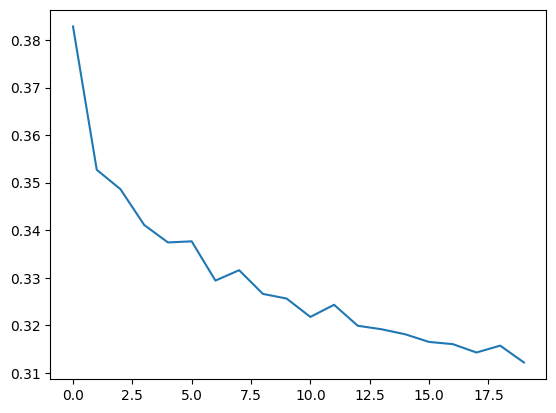

In [24]:
## Let's check out our loss graph
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1)) 

### Dev and test set evaluation 

In [26]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')


train 2.0384974479675293
val 2.095392942428589
test 2.0937764644622803


### Sampling! Woohoo!

In [35]:
# sample from the model. 20 names here

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all '...'
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item() # Returns index based on prob distr.
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

reigen.
selina.
denris.
kinden.
kinta.
xyav.
khaile.
magaceah.
kealene.
karan.
chartot.
tylan.
mirrick.
kaaja.
salyah.
questin.
joely.
eyah.
arterneld.
josaly.


From the comments of the above codeblock:
Btw, if you didn't run the "set self.training to false" above, this code would still work but it's using the wrong variables -- like the batchnorm would be doin le stuff on the wrong vars (over whole training set inputted) instead of the running vars. 

 And you could definitely tell if it's fucked in the sampling, because it would give an error: you can't get the variance of a single sample! (srs, it gives 'nan'. Also, it doesn't make sense to find spread of 1 sample) 